# Overcomplete Tomography

In [1]:
from octo.octo import OvercompleteBasis
from octo.basis import PixelBasis2D, CosineBasis2D
from octo.measurement import PathIntegral

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
rng = np.random.default_rng(42)

In [12]:
Nx = 20
Ny = 20
cosine = CosineBasis2D(Nx, Ny)
pixel = PixelBasis2D(Nx, Ny)
nparams = cosine.N + pixel.N

## Synthetic Data

Start by creating a ground truth image, combining global and local features

[(-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5)]

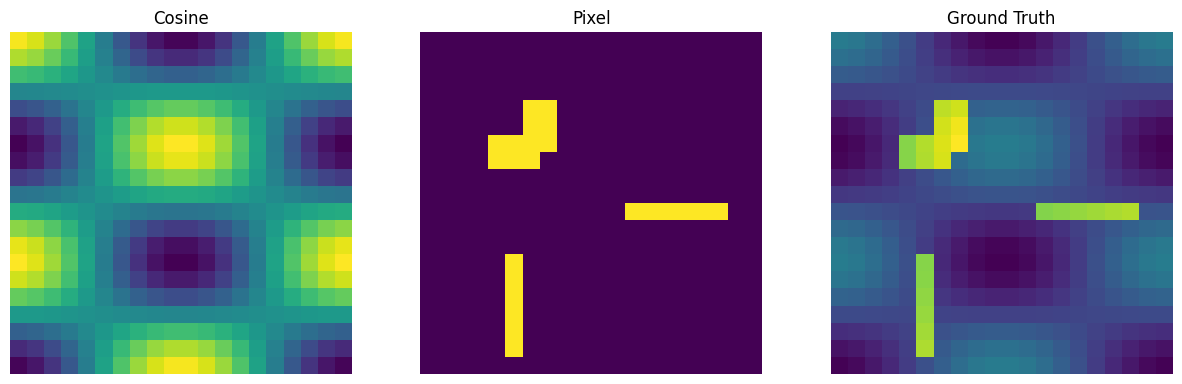

In [26]:
true_cosine_coefficients = np.zeros((Nx * Ny))
# true_cosine_coefficients[rng.integers(0, Nx * Ny, 10)] = rng.uniform(-1, 1, 10)
true_cosine_coefficients[3 * Ny + 2] = 1
true_cosine_image = cosine(true_cosine_coefficients)

true_pixel_coefficients = np.zeros((Nx, Ny))
true_pixel_coefficients[4:7, 6:8] = 0.3
true_pixel_coefficients[6:8, 4:7] = 0.3
true_pixel_coefficients[10, 12:18] = 0.3
true_pixel_coefficients[13:19, 5] = 0.3
true_pixel_coefficients = true_pixel_coefficients.flatten()
true_pixle_image = pixel(true_pixel_coefficients)

true_image = true_pixle_image + true_cosine_image

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(true_cosine_image.reshape(Nx, Ny))
axs[0].set_title("Cosine")

axs[1].imshow(true_pixle_image.reshape(Nx, Ny))
axs[1].set_title("Pixel")

axs[2].imshow(true_image.reshape(Nx, Ny))
axs[2].set_title("Ground Truth")

[ax.axis("off") for ax in axs]

Create a synthetic noiseless dataset.  The forward model here is simple path integration for paths that travel all the way across the image

$$d_i = \int_{\Gamma_i} f(x,y) \mathrm{d}s_i$$

(-0.5, 19.5, 19.5, -0.5)

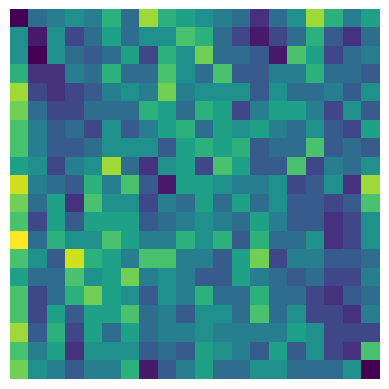

In [22]:
npaths=200
measurement = PathIntegral(Nx, Ny, npaths=npaths)

pm = np.sum(measurement.path_matrix.reshape((npaths, Nx, Ny)), axis=0)
plt.imshow(pm)
plt.gca().axis("off")

In [6]:
synthetic = measurement(true_image)

## Overcomplete Basis

Create an overcomplete basis, weighting the two bases and overall regularisation evenly

In [7]:
cosine.compute_jacobian(measurement)
pixel.compute_jacobian(measurement)
overcomplete = OvercompleteBasis(synthetic, [cosine, pixel])

## Solve the inverse problem

Minimise the cost function

In [17]:
# should implement a cost function gradient for faster convergence
result = minimize(overcomplete.cost, np.zeros((nparams)), method='L-BFGS-B', options={'disp': True, 'maxiter': 1})

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          800     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.10863D+01    |proj g|=  5.91614D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  800      1     21      1     0     0   5.916D+01   4.109D+01
  F =   41.086342415555592     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


[(-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5)]

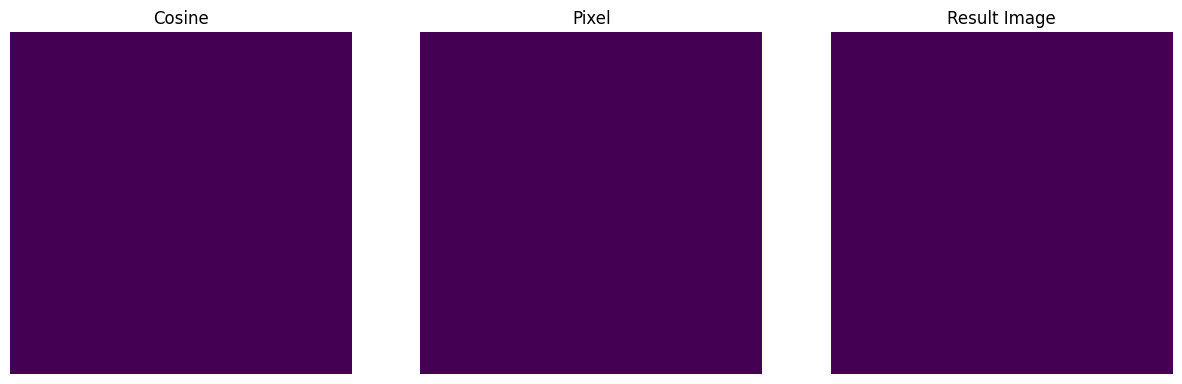

In [27]:
result_coefficients = overcomplete._split(result.x)

result_cosine_image = cosine(result_coefficients[0])
result_pixel_image = pixel(result_coefficients[1])
result_image = result_cosine_image + result_pixel_image

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(result_cosine_image.reshape(Nx, Ny))
axs[0].set_title("Cosine")

axs[1].imshow(result_cosine_image.reshape(Nx, Ny))
axs[1].set_title("Pixel")

axs[2].imshow(result_cosine_image.reshape(Nx, Ny))
axs[2].set_title("Result Image")

[ax.axis("off") for ax in axs]

[(-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5), (-0.5, 19.5, 19.5, -0.5)]

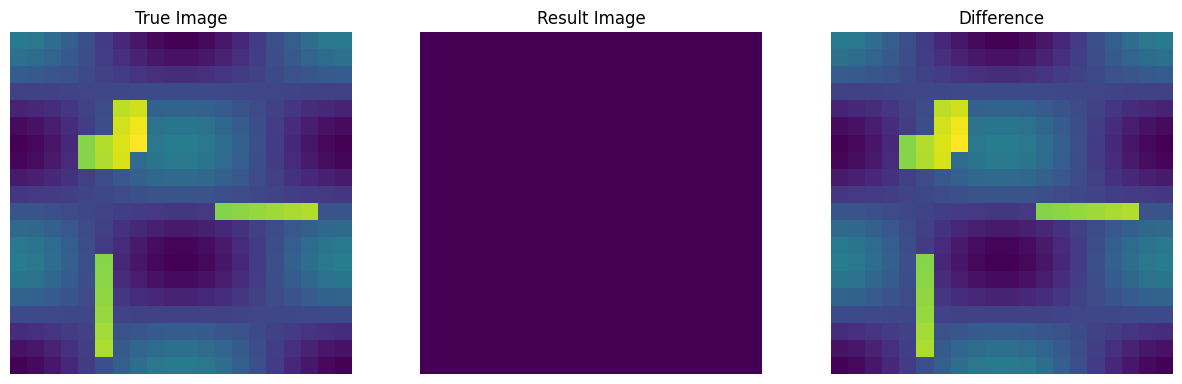

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(true_image.reshape(Nx, Ny))
axs[0].set_title("True Image")

axs[1].imshow(result_image.reshape(Nx, Ny))
axs[1].set_title("Result Image")

axs[2].imshow((true_image - result_image).reshape(Nx, Ny))
axs[2].set_title("Difference")

[ax.axis("off") for ax in axs]